# Imports

In [1]:
import logging
from contextlib import contextmanager

import numpy as np
from tqdm.notebook import tqdm

from khan_helpers import Experiment
from khan_helpers.constants import (
    FIG_DIR, 
    BOS_LECTURE_COLOR, 
    BOS_QUESTION_COLOR, 
    FORCES_LECTURE_COLOR, 
    FORCES_QUESTION_COLOR,
    GENERAL_QUESTION_COLOR
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define functions

In [2]:
@contextmanager
def disable_logging(module, level='CRITICAL'):
    """
    temporarily disable logging from `module` for messages less severe 
    than `level`.
    """
    
    if module not in logging.root.manager.loggerDict:
        raise ValueError(f"no logger exists for module '{module}'")
        
    logger = logging.getLogger(module)
    old_level = logger.level
    logger.setLevel(level.upper())
    try:
        yield
    finally:
        logger.setLevel(old_level)

# Load data, set constants

In [3]:
exp = Experiment()

GRID_RESOLUTION = 100
CMAP = 'bone'
LECTURE_LINEWIDTH = 1.5
QUESTION_SIZE = 40

# Uniformly shift embeddings to line up with heatmap bounds for plotting

In [4]:
embeddings = np.vstack((exp.forces_embedding, 
                        exp.bos_embedding, 
                        exp.question_embeddings))

# create a 2D grid over the embedding space
x_min, y_min = embeddings.min(axis=0) // 1 - 3
x_max, y_max = embeddings.max(axis=0) // 1 + 3

xs = np.linspace(x_min, x_max, GRID_RESOLUTION, endpoint=True)
ys = np.linspace(y_min, y_max, GRID_RESOLUTION, endpoint=True)

vertices = np.array([(x_coord, y_coord) for y_coord in ys for x_coord in xs])

all_coords = [exp.forces_embedding, 
              exp.bos_embedding, 
              exp.question_embeddings, 
              vertices]
split_inds = np.cumsum([arr.shape[0] for arr in all_coords])[:-1]
shifted = np.vstack(all_coords)
shifted -= shifted.min(axis=0)
shifted /= (shifted.max(axis=0) / GRID_RESOLUTION)

forces_lecture, bos_lecture, questions = np.vsplit(shifted, split_inds)[:-1]
forces_qs, bos_qs, general_qs = np.split(questions, (15, 30))

# Plot individual knowledge maps for each quiz, separately

  0%|          | 0/150 [00:00<?, ?it/s]

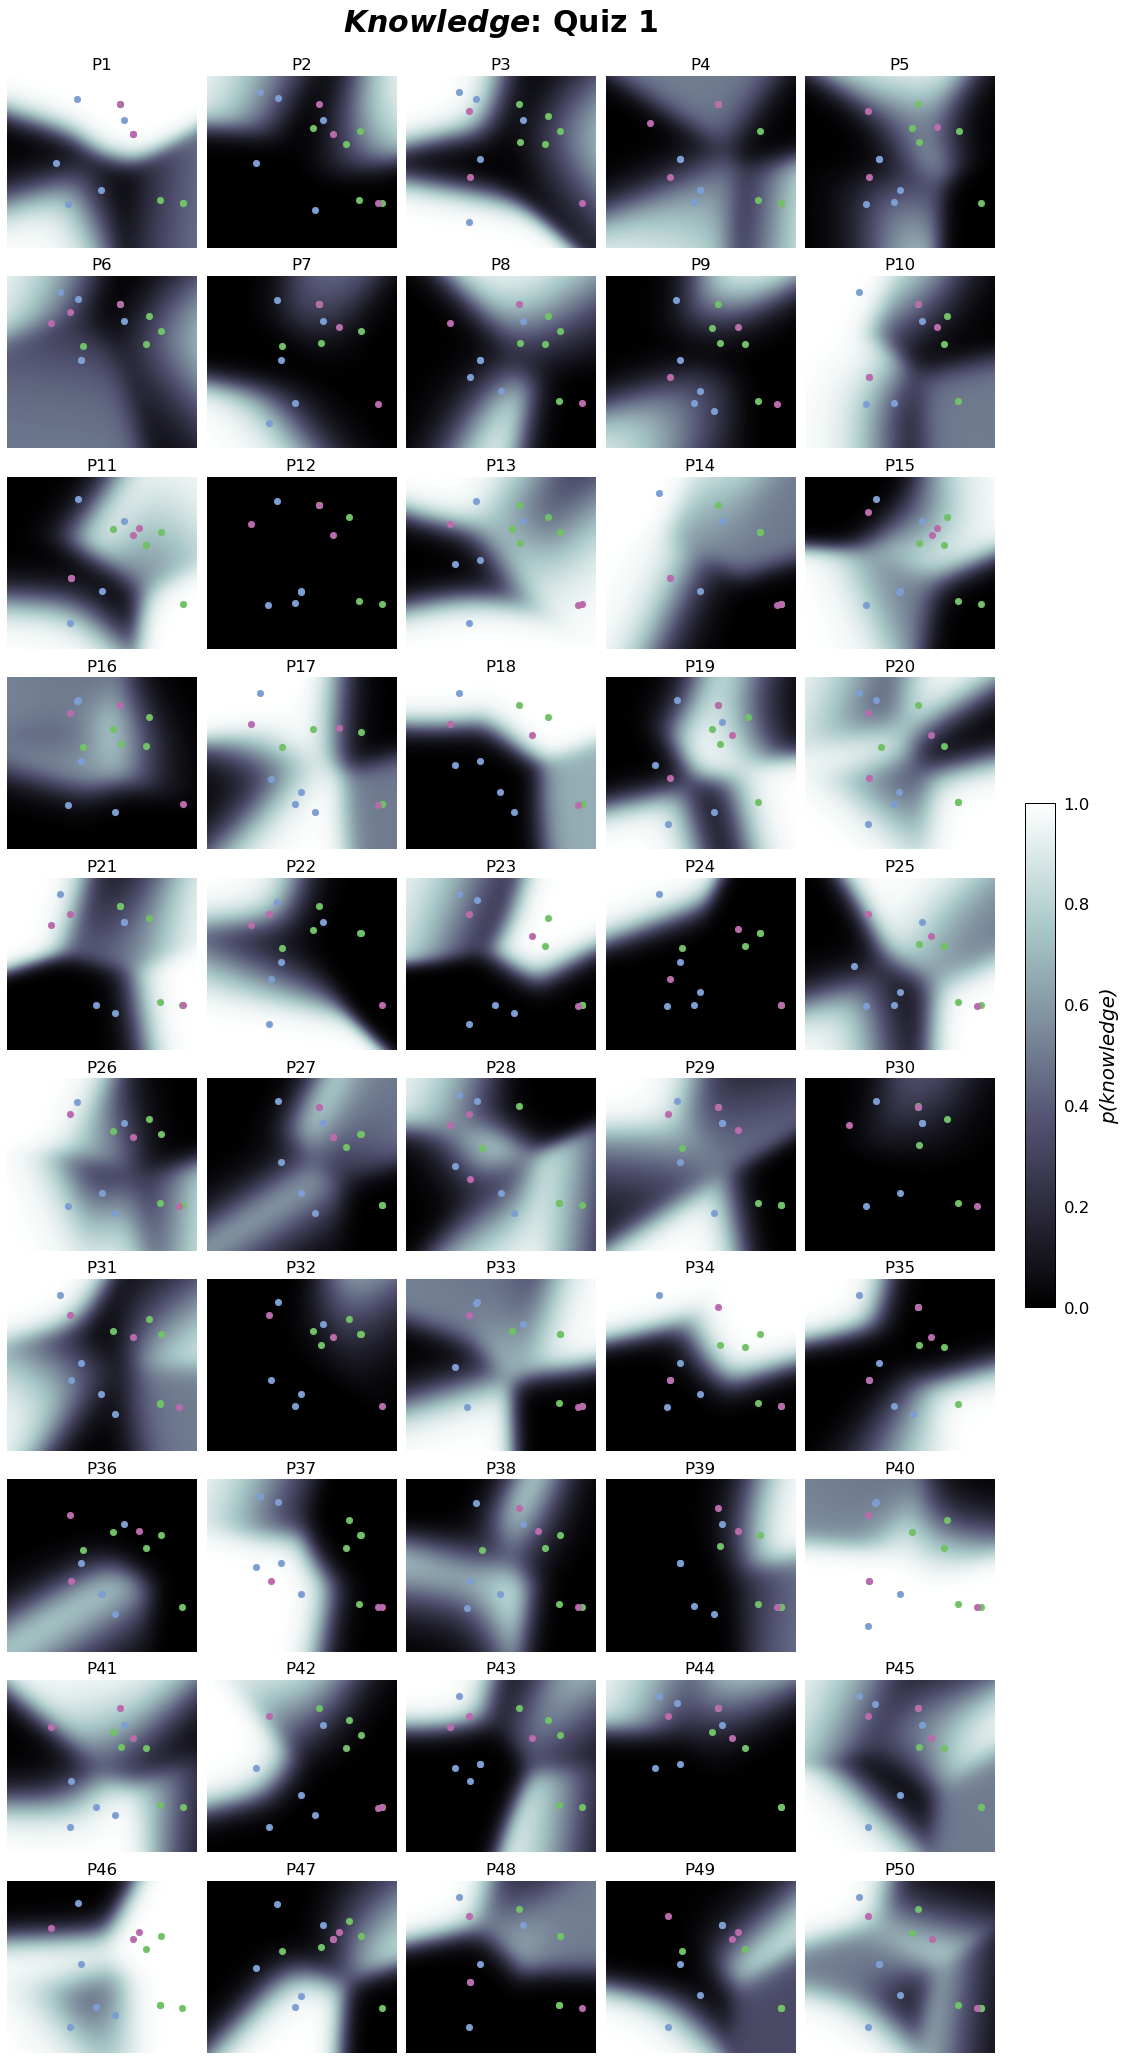

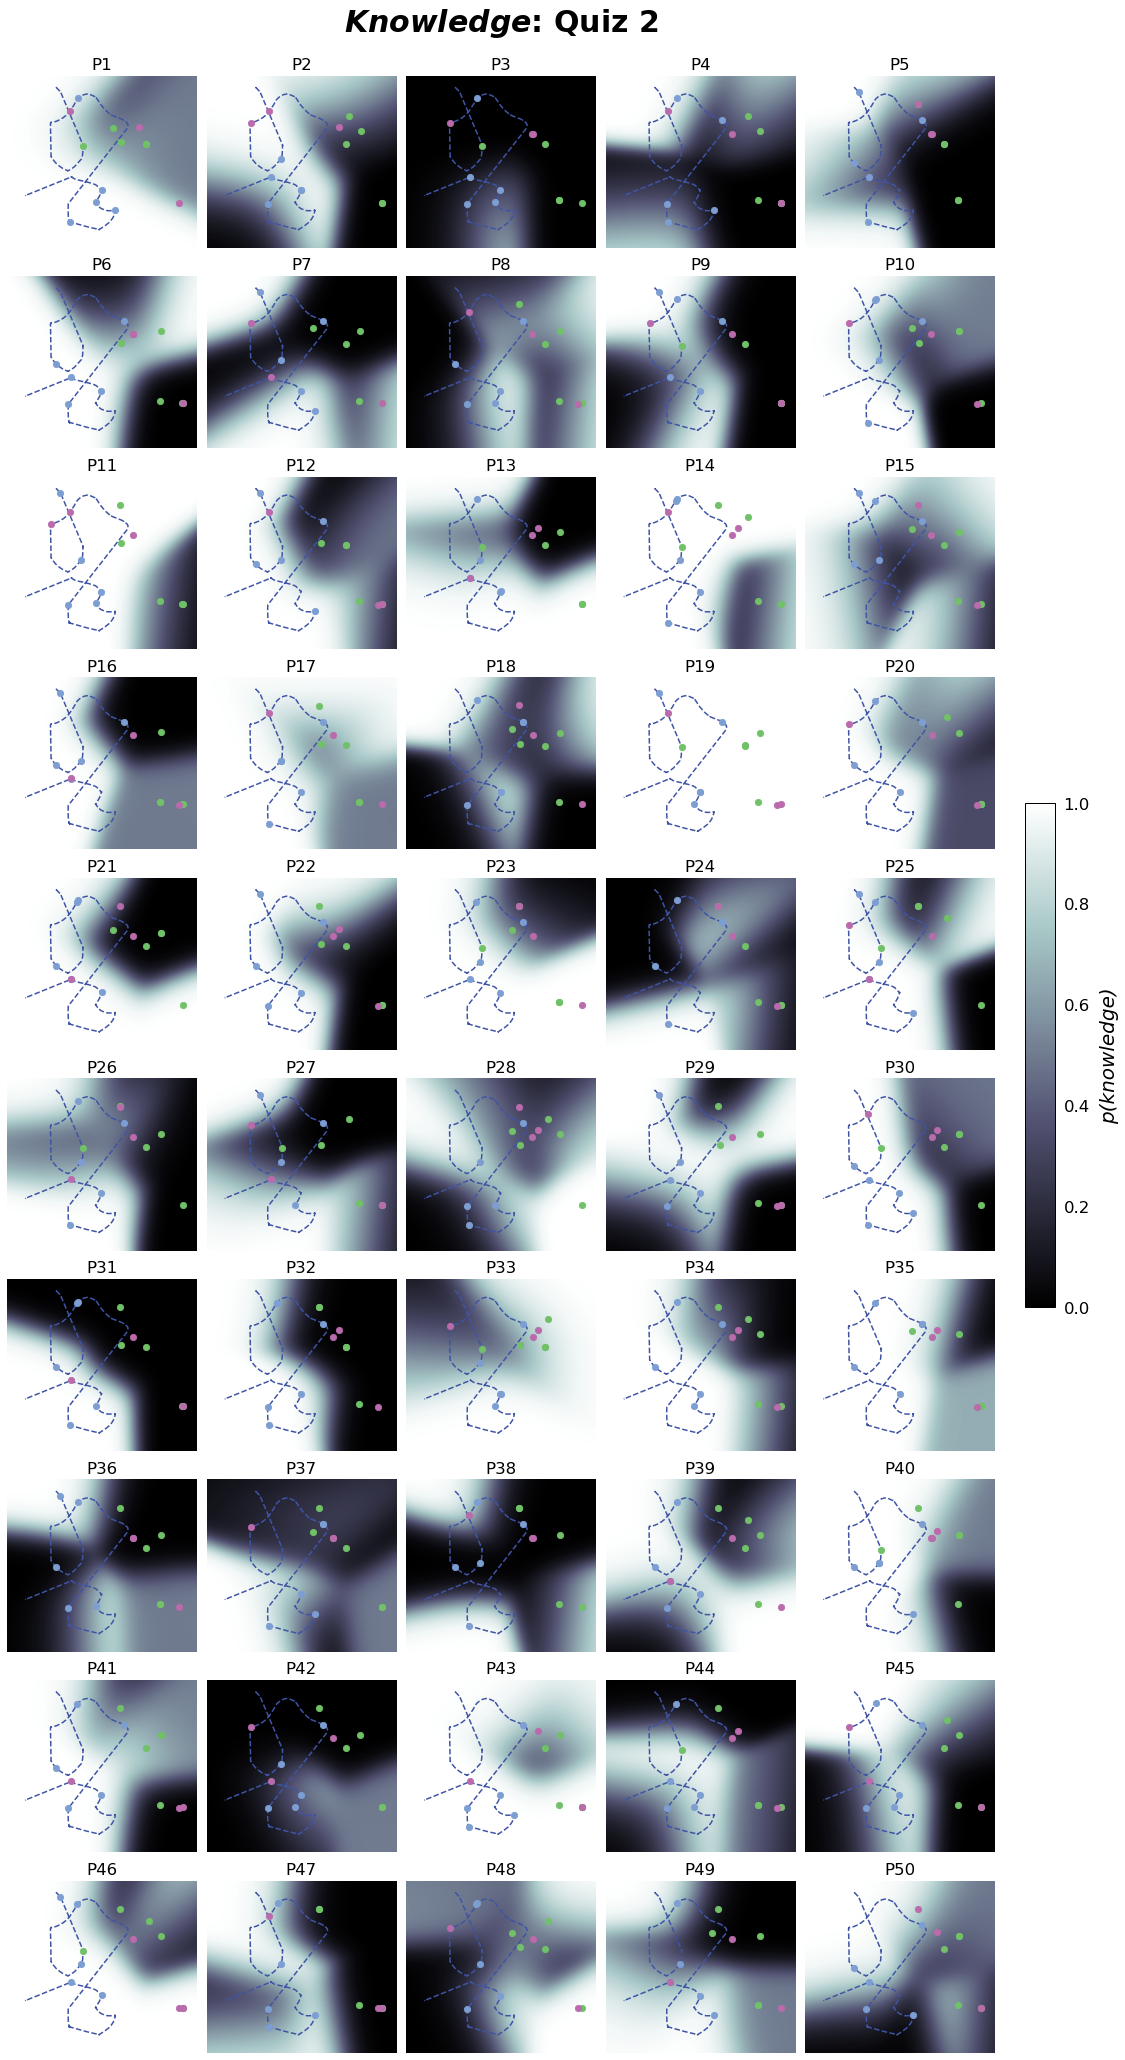

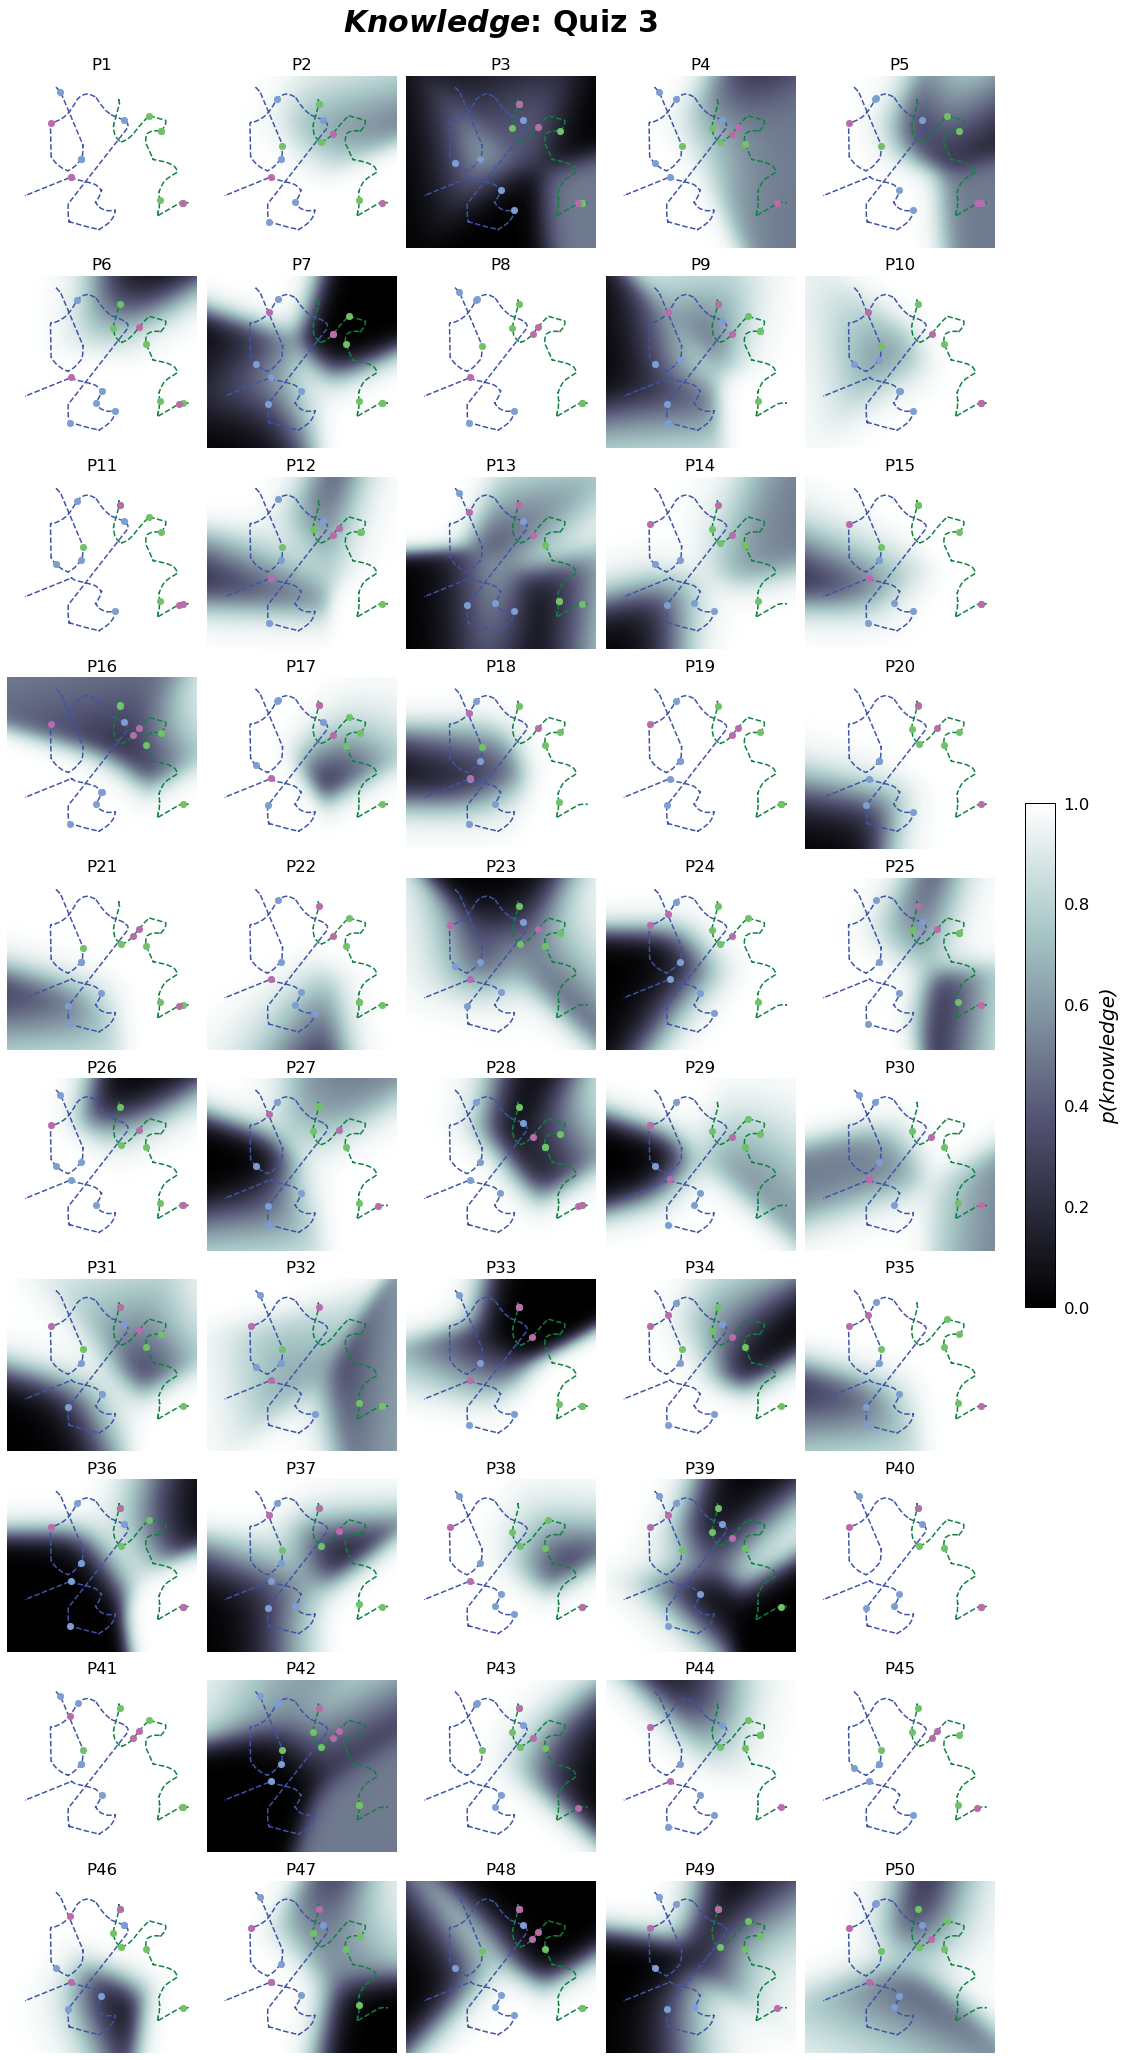

In [120]:
with (
    sns.plotting_context('paper'), 
    tqdm(total=len(exp.participants)*3, leave=False) as pbar
):
    for quiz in range(1, 4):
        pbar.set_description(f'Quiz {quiz}')
        fig, axarr = plt.subplots(10, 5, figsize=(14, 28))
        axarr = axarr.flatten()
        
        for p, ax in zip(exp.participants, axarr):
            # get participant's knowledge map for this quiz
            kmap = p.knowledge_maps[f'forces_bos_quiz{quiz}']
            # get questions participant answered on this quiz
            general_qids, forces_qids, bos_qids = (p.get_data(quiz=quiz-1)
                                                   .set_index('qID')
                                                   .groupby('lecture')
                                                   .groups.values())

            # knowledge estimate heatmap
            ax.imshow(kmap,
                      vmin=0,
                      vmax=1,
                      aspect='auto',
                      cmap=CMAP,
                      interpolation='bilinear')
            
            # Four Fundamental Forces quiz questions
            ax.scatter(questions[forces_qids - 1, 0],
                       questions[forces_qids - 1, 1],
                       c=FORCES_QUESTION_COLOR,
                       marker='o',
                       s=QUESTION_SIZE,
                       zorder=2)
            # Birth of Stars quiz questions
            ax.scatter(questions[bos_qids - 1, 0], 
                       questions[bos_qids - 1, 1], 
                       c=BOS_QUESTION_COLOR, 
                       marker='o', 
                       s=QUESTION_SIZE, 
                       zorder=2)
            # general physics knowledge quiz questions
            ax.scatter(questions[general_qids - 1, 0],
                       questions[general_qids - 1, 1],
                       c=GENERAL_QUESTION_COLOR,
                       marker='o',
                       s=QUESTION_SIZE,
                       zorder=2)
            # Four Fundamental Forces lecture trajectory
            if quiz > 1:
                ax.plot(forces_lecture[:, 0], 
                        forces_lecture[:, 1], 
                        c=FORCES_LECTURE_COLOR,
                        linestyle='--', 
                        linewidth=LECTURE_LINEWIDTH, 
                        zorder=1)
                # Birth of Stars lecture trajectory
                if quiz == 3:
                    ax.plot(bos_lecture[:, 0], 
                            bos_lecture[:, 1], 
                            c=BOS_LECTURE_COLOR,
                            linestyle='--',
                            linewidth=LECTURE_LINEWIDTH, 
                            zorder=1)

            ax.axis('off')
            ax.set_title(p.subID, fontsize='xx-large')
            # undo automatic y-axis inversion from sns.heatmap
            ax.invert_yaxis()

        # call tight_layout before adding colorbar
        plt.tight_layout()
        
        cbar_ax = fig.add_axes((1.02, 0.375, 0.03, 0.25))
        cbar = fig.colorbar(ax.images[0], cax=cbar_ax)
        cbar_ax.tick_params(right=False, labelsize='xx-large')
        cbar.set_label('p(knowledge)', size=20, labelpad=10, style='italic')
            
        with (
            # temporarily suppress harmless logged warnings:
            #     findfont: Font family ['cursive'] not found. Falling 
            #     back to DejaVu Sans.
            # and
            #     findfont: Generic family 'cursive' not found because 
            #     none of the following families were found: Apple 
            #     Chancery, Textile, Zapf Chancery, Sand, Script MT, 
            #     Felipa, Comic Neue, Comic Sans MS, cursive
            #
            # need to set 'mathtext.fontset' = 'custom' in order to set
            # 'mathtext.bf', but when 'mathtext.fontset' = 'custom',
            # matplotlib also tries to set 'mathtext.cal' = 'cursive'
            # internally and issues a warning because no cursive font 
            # families are installed in analysis container
            disable_logging('matplotlib.font_manager', 'ERROR'), 
            # make \mathit{} font bold & italic
            plt.rc_context({
                'mathtext.fontset': 'custom', 
                'mathtext.it': 'sans:bold:italic'
            })
        ):
            fig.suptitle(f'$\\mathit{{Knowledge}}$: Quiz {quiz}', 
                         y=1.02, 
                         fontsize=30,
                         fontweight='bold')
#             plt.savefig(FIG_DIR.joinpath(f'individual_knowledge_maps_quiz{quiz}.pdf'), 
#                         bbox_inches='tight', 
#                         dpi=150)
            plt.show()
#         break

# Plot individual learning maps

# Plot individual knowledge & learning maps

**_NOTE: PLOT TAKES ~20 MINUTES TO GENERATE_**

In [5]:
# with sns.plotting_context('paper'):
#     n_rows = N_PARTICIPANTS * 4
#     n_cols = 6

#     fig = plt.figure(figsize=(14, 8 * N_PARTICIPANTS))
#     # set up subplot layout
#     axarr = []
#     for sub_n in range(N_PARTICIPANTS):
#         row_ix = sub_n * 4
#         # row of 3 knowledge maps
#         kmap1 = plt.subplot2grid((n_rows, n_cols), (row_ix, 0), colspan=2, rowspan=2)
#         kmap2 = plt.subplot2grid((n_rows, n_cols), (row_ix, 2), colspan=2, rowspan=2)
#         kmap3 = plt.subplot2grid((n_rows, n_cols), (row_ix, 4), colspan=2, rowspan=2)
#         # row of 2 learning maps
#         lmap1 = plt.subplot2grid((n_rows, n_cols), (row_ix + 2, 1), colspan=2, rowspan=2)
#         lmap2 = plt.subplot2grid((n_rows, n_cols), (row_ix + 2, 3), colspan=2, rowspan=2)
#         axarr.append([kmap1, kmap2, kmap3, lmap1, lmap2])

#     # call tight_layout before adding colorbar axes so bounding boxes are set properly
#     plt.tight_layout()

#     # hack to add colorbar axes to each row without cutting into rightmost heatmap
#     cbar_axarr = []
#     for sub_axes in axarr:
#         kmap3_bbox = sub_axes[2].get_position()
#         lmap2_bbox = sub_axes[4].get_position()
#         kmap_cax = fig.add_axes([
#             kmap3_bbox.xmax * 1.01, 
#             kmap3_bbox.y0, 
#             kmap3_bbox.width * 0.05, 
#             kmap3_bbox.height
#         ])
#         lmap_cax = fig.add_axes([
#             lmap2_bbox.xmax * 1.01, 
#             lmap2_bbox.y0, 
#             lmap2_bbox.width * 0.05, 
#             lmap2_bbox.height
#         ])
#         cbar_axarr.append([kmap_cax, lmap_cax])

#     # loop over participants/axes/colorbar axes
#     for sub_n in trange(N_PARTICIPANTS):
#         sub = exp.participants[sub_n]
#         sub_axes = axarr[sub_n]
#         sub_kmap_axes, sub_lmap_axes = sub_axes[:3], sub_axes[3:]
#         kmap_cbar_ax, lmap_cbar_ax = cbar_axarr[sub_n]

#         # precompute vmin & vmax for each row so shared colorbar is accurate
#         kmaps = [sub.get_kmap(f'forces_bos_qset{qset}') for qset in range(3)]
#         lmaps = [kmaps[qset + 1] - kmaps[qset] for qset in range(2)]
#         kmap_vmin, kmap_vmax = np.min(kmaps), np.max(kmaps)
#         lmap_vmin, lmap_vmax = np.min(lmaps), np.max(lmaps)

#         # plot knowledge map
#         for i, kmap in enumerate(kmaps):
#             ax = sub_kmap_axes[i]
#             # turn colorbar on for last plot in row
#             cbar = True if i == 2 else False
#             cbar_ax = kmap_cbar_ax if cbar else None
#             # create background heatmap
#             sns.heatmap(kmap, 
#                         vmin=kmap_vmin, 
#                         vmax=kmap_vmax, 
#                         xticklabels=[], 
#                         yticklabels=[], 
#                         cmap=cmap, 
#                         cbar=cbar, 
#                         ax=ax, 
#                         cbar_ax=cbar_ax)
#             # rasterize
#             ax.collections[0].remove()
#             ax.imshow(kmap, 
#                       vmin=kmap_vmin, 
#                       vmax=kmap_vmax, 
#                       aspect='auto', 
#                       cmap=cmap)

#             # plot questions from current question set
#             qset_data = sub.get_data(qset=i)
#             g_qIDs, f_qIDs, b_qIDs = qset_data.groupby('lecture')['qID'].groups.values()

#             ax.scatter(questions[f_qIDs - 1, 0], questions[f_qIDs - 1, 1], 
#                        c='r', marker='o', s=50, alpha=.7)
#             ax.scatter(questions[b_qIDs - 1, 0], questions[b_qIDs - 1, 1], 
#                        c='g', marker='o', s=50, alpha=.7)
#             ax.scatter(questions[g_qIDs - 1, 0], questions[g_qIDs - 1, 1], 
#                        c='b', marker='o', s=50, alpha=.7)

#             # overlay previously viewed lectures
#             if i > 0:
#                 ax.plot(forces[:, 0], forces[:, 1], 'r--', alpha=.7, linewidth=2)
#             if i == 2:
#                 ax.plot(bos[:, 0], bos[:, 1],'g--', alpha=.7, linewidth=2)

#             ax.set_title(f'P{sub_n + 1} knowledge: question block {i + 1}', 
#                          fontsize='large')

#             # undo automatic y-axis inversion from sns.heatmap
#             ax.invert_yaxis()

#         # plot learning maps
#         for i, lmap in enumerate(lmaps):
#             ax = sub_lmap_axes[i]
#             cbar = True if i == 1 else False
#             cbar_ax = lmap_cbar_ax if cbar else None
#             sns.heatmap(lmap, vmin=lmap_vmin, vmax=lmap_vmax, xticklabels=[], 
#                         yticklabels=[], cmap=cmap, cbar=cbar, ax=ax, cbar_ax=cbar_ax)
#             ax.collections[0].remove()
#             ax.imshow(lmap, vmin=lmap_vmin, vmax=lmap_vmax, aspect='auto', cmap=cmap)

#             # plot questions from "before" and "after" question sets
#             qset_data = sub.get_data(qset=i)
#             qset_data = sub.get_data(qset=range(i, i + 2))
#             g_qIDs, f_qIDs, b_qIDs = qset_data.groupby('lecture')['qID'].groups.values()
#             ax.scatter(questions[f_qIDs - 1, 0], 
#                        questions[f_qIDs - 1, 1], 
#                        c='r', 
#                        marker='o', 
#                        s=50, 
#                        alpha=.7)
#             ax.scatter(questions[b_qIDs - 1, 0], 
#                        questions[b_qIDs - 1, 1], 
#                        c='g', 
#                        marker='o', 
#                        s=50, 
#                        alpha=.7)
#             ax.scatter(questions[g_qIDs - 1, 0], 
#                        questions[g_qIDs - 1, 1], 
#                        c='b', 
#                        marker='o', 
#                        s=50, 
#                        alpha=.7)

#             # overlay lecture viewed viewed between the two question sets
#             if i == 0:
#                 ax.plot(forces[:, 0], forces[:, 1], 'r--', alpha=.7, linewidth=2)
#             else:
#                 ax.plot(bos[:, 0], bos[:, 1],'g--', alpha=.7, linewidth=2)

#             ax.set_title(fr'P{sub_n + 1} learning: question block {i + 1} $\rightarrow$ {i + 2}', 
#                          fontsize='large')
#             ax.invert_yaxis()

#     # NOTE: DPI must be <= (2 ** 16) / 400 for matplotlib to save file
#     plt.savefig(FIG_DIR.joinpath('individual_maps.pdf'), bbox_inches='tight', dpi=150)
#     # figure is too large to display in notebook without crashing Jupyter kernel
#     plt.close()